In [1]:
import observational_fear.load as load
from observational_fear.nbox_transforms import (
    summarize_prepost_events,
    wilcoxon_by_cell,
)
from observational_fear.events import get_block_starts
from observational_fear.stats import auc
from neurobox.wide_transforms import resample
from pathlib import Path
import pandas as pd
import numpy as np
from binit.align import align_around
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from observational_fear.events import get_freeze_starts
from neurobox.long_transforms import align_to_events
from observational_fear.nbox_transforms import align_to_data_by, exclude_short_trials
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.base import clone
sns.set_style("whitegrid")

DATA_DIR = Path(r"D:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")


In [2]:
def get_bloc_psth(df, cs_starts):
    df = df.reset_index().melt(id_vars=["time"])
    return (
        df
        .assign(
            aligned=lambda x: np.round(
                align_around(x["time"].values, cs_starts, t_before=5, max_latency=5), 2
            )
        )
        .pivot_table(columns="new_id", values="value", index="aligned")
        .apply(zscore)
    )


def shuffle_block(df_traces, block_starts, pipe):
    shuffled_scores = []
    for i in range(10):
        df_shuffled = df_traces.sample(frac=1).copy()
        df_shuffled.index = df_traces.index

        df_shuffled = get_bloc_psth(df_shuffled, block_starts)
        X = df_shuffled.dropna()
        y = np.where(df_shuffled.index <= 0, "ITI", "CS")
        pipe1 = clone(pipe)

        scores=cross_val_score(pipe1, X=X, y=y, scoring="f1_macro")
        shuffled_scores.append(scores)
    return shuffled_scores

def plot_pcs(X, y, **kwargs):
    to_plot = pd.DataFrame(PCA(10).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(color=X.index)
    to_plot["y"] = y
    return sns.lineplot(x="PC1", y="PC2", hue="y", data=to_plot, ci=None, **kwargs)
    


# Day 2 CS

In [3]:
SESSION = "day2"
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\OFL\\one-p experiment\\data\\day2-traces.parquet.gzip'

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

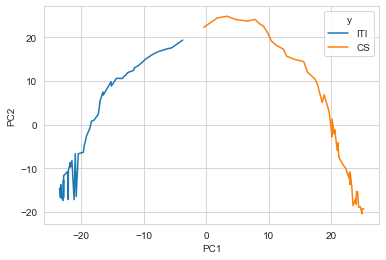

In [ ]:
df_real = df
cs_starts = get_block_starts(session="day2", block_name="CS")
get_bloc_psth
X = get_bloc_psth(df_real, cs_starts)

y = np.where(X.index <= 0, "ITI", "CS")
pipe = make_pipeline(PCA(2), LogisticRegression())
obs = cross_val_score(clone(pipe), X, y)
# reps = shuffle_block(df, cs_starts, pipe)

plot_pcs(X, y)

# Day 2 US

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

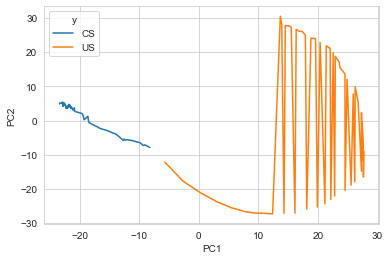

In [157]:
df_real = df
cs_starts = get_block_starts(session="day2", block_name="US")
get_bloc_psth
X = get_bloc_psth(df_real, cs_starts)

y = np.where(X.index <= 0, "CS", "US")
pipe = make_pipeline(PCA(2), LogisticRegression())
obs = cross_val_score(clone(pipe), X, y)
# reps = shuffle_block(df, cs_starts, pipe)

plot_pcs(X, y)

In [165]:
# Day 4 CS
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df = df.reset_index().melt(id_vars=["time"])

results_day2_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day2.csv")
df_freeze = load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing_dem", mouse_col="mouse_name"
)

df_events = events_day2_freeze_starts.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day2_freeze_starts = exclude_short_trials(traces_day2_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

df = (
    traces_day2_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)

df_events

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


,mouse,freeze_start
0,B17274,0.666667
1,B17274,7.833333
2,B17274,10.033333
3,B17274,44.700000
4,B17274,47.333333
...,...,...
1940,PL-OFL-7,2084.033333
1941,PL-OFL-7,2088.966667
1942,PL-OFL-7,2098.600000
1943,PL-OFL-7,2115.833333


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

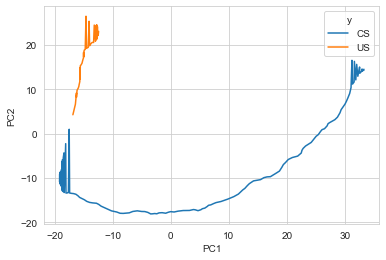

In [168]:
X = df

y = np.where(X.index <= 0, "CS", "US")
pipe = make_pipeline(PCA(2), LogisticRegression())
obs = cross_val_score(clone(pipe), X, y)

obs
plot_pcs(X, y)

In [164]:
# 1: Calculate Average Trace, Decompose, Classif
# 
# y
df

<function observational_fear.load.load_traces(data_dir: pathlib.Path, session: str) -> pandas.core.frame.DataFrame>

In [124]:
# 2: Align and decompose each trial, classify


In [ ]:
# 3: Decompose, de

In [144]:

X = df_real.dropna()
y = np.where(df_shuffled.index <= 0, "ITI", "CS")

pipe = make_pipeline(
    PCA(2), 
    LogisticRegression()
    )
real_scores = cross_val_score(pipe, X=X, y=y, scoring="f1_macro")
real_scores

array([0.85176471, 1.        , 1.        , 1.        , 0.8989899 ])

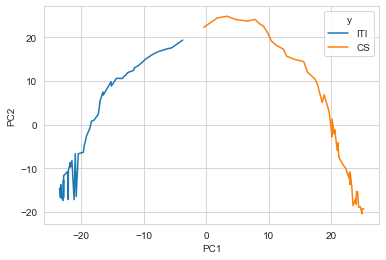

In [145]:
to_plot = pd.DataFrame(PCA(10).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(color=X.index)
to_plot["y"] = y
sns.lineplot(x="PC1", y="PC2", hue="y", data=to_plot, ci=None)
plt.savefig("CS classification tradjectory.svg")

In [116]:
X = df_shuffled.dropna()
y = np.where(df_shuffled.index <= 0, "ITI", "CS")

pipe = make_pipeline(PCA(2), LogisticRegression())
cross_val_score(pipe, X=X, y=y, scoring="f1_macro")

<Figure size 432x288 with 0 Axes>

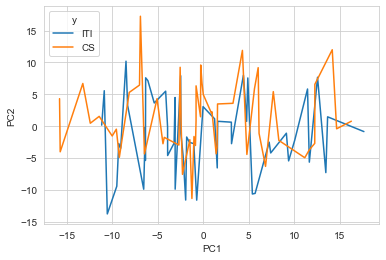

In [117]:
import seaborn as sns

to_plot = pd.DataFrame(PCA(10).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(color=X.index)
to_plot["y"] = y
sns.lineplot(x="PC1", y="PC2", hue="y", data=to_plot, ci=None)
plt.savefig("Shuffled classification tradjectory.svg")

In [120]:
shuffled_scores = []
for i in range(10):
    df_shuffled = df.sample(frac=1).copy()
    df_shuffled.index = df.index
    df_shuffled = prep_data(df_shuffled, cs_starts)
    X = df_shuffled.dropna()
    y = np.where(df_shuffled.index <= 0, "ITI", "CS")

    pipe = make_pipeline(PCA(2), LogisticRegression())
    scores=cross_val_score(pipe, X=X, y=y, scoring="f1_macro")
    shuffled_scores.append(scores)

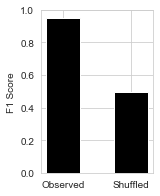

In [143]:
reps = np.array([x.mean() for x in shuffled_scores])
obs = real_scores.mean()
(reps > obs).mean()
plt.figure(figsize=(2, 3))
plt.bar(["Observed", "Shuffled"], [obs, reps.mean()], color="black", width=0.5)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.savefig("CS Decoding result.svg")

In [133]:
reps

array([0.46514939, 0.39325829, 0.44477444, 0.58553984, 0.60662157,
       0.4402997 , 0.58437748, 0.52039717, 0.42254895, 0.46384218])

In [27]:
from sklearn.decomposition import PCA

mod = PCA().fit(dfp)
num_pcs = np.sum(np.cumsum(mod.explained_variance_ratio_) <= 0.9)

X = PCA(num_pcs).fit_transform(dfp)


In [121]:
X

new_id,0,1,10,1000,1003,1004,1005,1006,1008,1009,...,974,977,979,984,986,988,989,994,997,999
aligned,,,,,,,,,,,,,,,,,,,,,
-5.0,-0.178139,0.170349,-0.591137,-0.544893,0.529204,2.693560,-2.120775,1.329219,2.009390,-0.702436,...,-0.600328,-0.007527,-1.161548,-0.950762,0.300943,0.168930,-0.845285,0.676029,0.341195,-0.224920
-4.9,1.163870,-0.458473,-0.822439,-1.200632,1.394031,0.314084,-0.837723,-0.518350,0.389389,0.314209,...,-0.678232,-0.729403,1.125281,-0.692614,-1.127705,1.880388,-0.777029,-0.188237,-0.214337,1.313716
-4.8,0.137410,-1.046497,0.515403,-0.683387,1.862329,0.992400,1.107891,-0.631396,-0.428604,0.782432,...,0.894310,2.384938,0.458855,1.133605,0.182520,2.293653,-0.930173,0.715744,-0.928672,-1.451983
-4.7,0.463954,0.207772,-0.579294,0.189018,-0.724749,0.312096,-1.026221,-0.888692,-0.290072,0.997017,...,0.074085,0.250130,-1.613901,0.362859,-0.051531,-0.406634,-0.824211,1.024782,-0.280564,-0.166983
-4.6,-0.462287,2.194010,-0.717469,-0.952682,0.277348,0.882356,-0.956396,-1.821839,-0.519654,0.545195,...,-1.426545,0.373563,-0.946585,1.042694,1.502690,0.107091,1.004947,-0.383949,-0.479272,-2.559717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.6,-0.771945,0.044722,0.501349,0.962280,4.594505,-0.668383,-1.065671,0.078960,0.196624,0.387198,...,0.343720,0.595483,-0.864167,-0.881111,-0.307583,0.453130,0.448535,-0.551271,-0.471718,-1.202468
4.7,1.610018,-0.184567,-0.572105,-0.481983,1.652591,0.007242,-1.047311,-1.797787,2.607285,-0.471469,...,-0.157427,-1.343177,-1.022112,0.079090,1.366309,-0.807837,-0.852551,-0.325437,0.881803,-0.899963
4.8,0.258089,-0.552794,-0.754070,-0.422865,0.636762,-0.358177,-0.599809,1.631993,0.564394,-0.612552,...,-1.172688,-1.471752,-0.334379,-1.905919,-0.063806,-0.910895,-0.706101,-0.001497,0.641102,1.996807


In [17]:
np.sum(np.cumsum(mod.explained_variance_ratio_) <= 0.9)

13